******************************
*        Parameters          *
******************************
Wheel Parameters
m_wheel = 0.05 (kg)
r_wheel = 0.05 (m)
I_wheel = 6.250000000000001e-05 (kg.m^2)

------------------------------
Pendulum Parameters
m_pendulum = 0.05 (kg)
r_pendulum = 0.19506836408466305 (m)
I_pendulum = 0.0019025833333333334 (kg.m^2)

------------------------------
Motor Parameters
kt = 0.317 (N.m/A)
kb = 0.468 (V.s/rad)
Rm = 6.69 (Ohm)
Im = 6.250000000000001e-05(kg.m^2)
Gear Ratio = 1.0


******************************
*  Matrix (continous time)   *
******************************
Matrix A (continuous time)
[[  0.           1.           0.           0.        ]
 [ 28.23226157   0.           0.          13.97633288]
 [  0.           0.           0.           1.        ]
 [-60.24169184   0.           0.         -88.95797268]]

------------------------------
Matrix B (continuous time)
[[  0.        ]
 [-29.86395914]
 [  0.        ]
 [190.0811382 ]]

-----------------------------

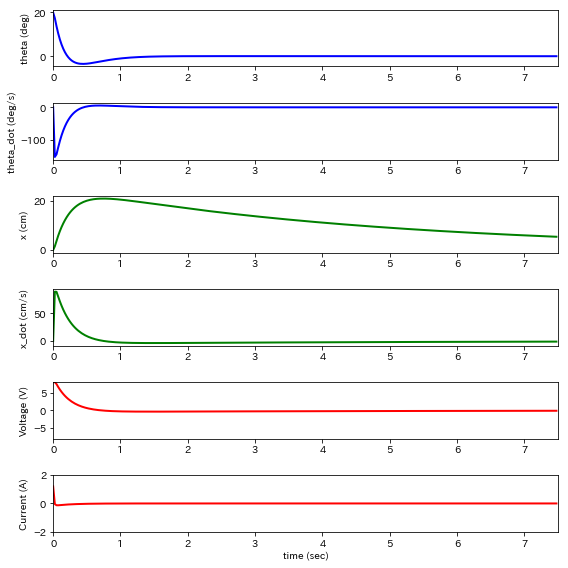

In [4]:
%matplotlib inline

#***********************************************************
#Inverted Pendulum
#Calculate the optimal feedback gain
#Simulate the motion
#2019/03/01 N. Beppu
#***********************************************************
import math
import numpy
import control
import matplotlib.pyplot as plt

# Physical constant
g = 9.81 # 重力

# Model parameters
m = 0.05 # 車輪と車軸の質量[Kg]
R = 0.05 # 車輪の半径[m]
Jw = R * R * m / 2.0 # 車輪と車軸の慣性モーメント[Kg m^2]
M = 0.79 # 本体の質量[Kg]
W = 0.12 # 本体の幅[m]
D = 0.08 # 本体の奥行き[m]
L = 0.085 # 車軸から本体重心までの距離[m]
D_the = 0.0 # 本体の粘性摩擦係数 [N m s/rad]
D_phi=0.8e-4 # 車軸の粘性摩擦係数 [N m s/rad]
Jpsi = M * L * L / 3.0 # 本体の慣性モーメント[Kg m^2]
Jphi = M * ((W * W) + (D * D)) / 12.0 # body raw interia moment [kg m^2]

# DC Motor Parameters
Jm = 1e-5 # DC motor inertia moment [kg m^2]
Rm = 6.69 # DC motor resistance [Ω]
Kb = 0.468 # DC motor back EMF constant
Kt = 0.317 # DC motor torque constant[N m/A]
n = 1 # gear ratio
 
#===========================================================
#Model parameters
#===========================================================
#-------------------------------------------------
#Tamiya sports tire set
#-------------------------------------------------
#The mass of the wheel (kg)
m_wheel = m
#The radius of the wheel (m)
r_wheel = R
#The moment of inertia of the wheel (kg.m^2)
I_wheel = 0.5 * m_wheel * r_wheel * r_wheel
 
#-------------------------------------------------
#Tamiya high power gear box HE
#gear ratio = 64.8
#-------------------------------------------------
#mass (kg)
# m_gear = 0.058
#length (m)
# x_gear = 0.028
# y_gear = 0.060
#The length between the center of gravity and the axis (m)
# d_gear = 0.020
#The moment of inertia of the gear box about the shaft (kg.m^2)
# I_gear = 1/12 * m_gear*(x_gear*x_gear + y_gear*y_gear) +\
# m_gear * d_gear * d_gear
#The gear ratio
# gear_ratio = 64.8   #high power gear box
gear_ratio = 1.0
 
#-------------------------------------------------
#Chassis (Tamiya universal plate L)
#-------------------------------------------------
#mass (kg)
# m_plate = 0.080 /2
#length (m)
# y_plate = 0.210
#The length between the center of gravity and the axis (m)
# d_plate = 0.095
#The moment of inertia of the universal plate about the shft (kg.m^2)
# I_plate = 1/12 * m_plate * y_plate * y_plate +\
# m_plate * d_plate * d_plate
 
#-------------------------------------------------
#Battery box (AA size x 4)
#-------------------------------------------------
#mass (kg)
# m_battery = 0.120 /2
#length (m)
# x_battery = 0.015
# y_battery = 0.056
#The length between the center of gravity and the axis (m)
# d_battery = 0.065
#The moment of inertia of the battery box about the shaft (kg.m^2)
# I_battery = 1/12 * m_battery*(x_battery*x_battery + y_battery*y_battery)
# m_battery * d_battery * d_battery
 
#-------------------------------------------------
#Circuit board (NUCLEO)
#-------------------------------------------------
#mass (kg)
# m_circuit = 0.100 /2
#length (m)
# x_circuit = 0.010
# y_circuit = 0.095
#The length between the center of gravity and the axis (m)
# d_circuit = 0.140
#The moment of inertia of the battery box about the shaft (kg.m^2)
# I_circuit = 1/12 * m_circuit*(x_circuit*x_circuit + y_circuit*y_circuit) +\
# m_circuit * d_circuit * d_circuit
 
#-------------------------------------------------
#Whole body
#-------------------------------------------------
#mass (kg)
# m_pendulum = m_gear + m_battery + m_plate + m_circuit
m_pendulum = m
#The moment of inertia (kg.m^2)
# I_pendulum = I_gear + I_battery + I_plate + I_circuit
I_pendulum = Jpsi
#The length between the center of gravity and the axis (m)
r_pendulum = math.sqrt(I_pendulum/m_pendulum)
 
#-------------------------------------------------
#Motor (RE-260RA-2670)
#-------------------------------------------------
#resistance
# Rm = 2.4
Rm = Rm
#The torque constant (N.m/A)
# kt = 0.0018
kt = Kt
#The back electromotive force constant (V.s/rad)
#kb = 0.0022
# kb = 0.0024
kb = Kb
#The mass of rotator (kg)
m_rotator = 0.010
#The radius of rotator (m)
r_rotator = 0.0075
#The moment of inertia of the rotator
# Im = 0.5*m_rotator*r_rotator*r_rotator
Im = Jw
 
#-------------------------------------------------
#parameter summary
#-------------------------------------------------
print("******************************")
print("*        Parameters          *")
print("******************************")
print("Wheel Parameters")
print("m_wheel = " + str(m_wheel) + " (kg)")
print("r_wheel = " + str(r_wheel) + " (m)")
print("I_wheel = " + str(I_wheel) + " (kg.m^2)\n")
 
print("------------------------------")
print("Pendulum Parameters")
print("m_pendulum = " + str(m_pendulum) + " (kg)")
print("r_pendulum = " + str(r_pendulum) + " (m)")
print("I_pendulum = " + str(I_pendulum) + " (kg.m^2)\n")
 
print("------------------------------")
print("Motor Parameters")
print("kt = " + str(kt) + " (N.m/A)")
print("kb = " + str(kb) + " (V.s/rad)")
print("Rm = " + str(Rm) + " (Ohm)")
print("Im = " + str(Im) + "(kg.m^2)")
print("Gear Ratio = " + str(gear_ratio) + "\n")
print("")
 
 
#===========================================================
#Calculate matrix A, B, C (continuous time)
#===========================================================
#-------------------------------------------------
#matrix A (continuous time)
#-------------------------------------------------
a11_temp = (m_wheel + m_pendulum) * r_wheel * r_wheel +\
2 * m_pendulum * r_wheel * r_pendulum +\
m_pendulum * r_pendulum * r_pendulum +\
I_pendulum +\
I_wheel
 
a12_temp = (m_wheel + m_pendulum) * r_wheel * r_wheel +\
m_pendulum * r_wheel * r_pendulum +\
I_wheel
 
a21_temp = (m_wheel + m_pendulum) * r_wheel * r_wheel +\
m_pendulum * r_wheel * r_pendulum +\
I_wheel
 
a22_temp = (m_wheel + m_pendulum) * r_wheel * r_wheel +\
I_wheel +\
gear_ratio * gear_ratio * Im
 
det = a11_temp*a22_temp - a12_temp*a21_temp
a11 = a22_temp/det
a12 = -a12_temp/det
a21 = -a21_temp/det
a22 = a11_temp/det
 
A = [\
[0, 1, 0, 0], \
[a11 * m_pendulum * 9.8 * r_pendulum, 0, 0, -1 * a12 * gear_ratio * gear_ratio * kt * kb / Rm], \
[0, 0, 0, 1], \
[a21 * m_pendulum * 9.8 * r_pendulum, 0, 0, -1 * a22 * gear_ratio * gear_ratio * kt * kb / Rm] \
]
A = numpy.array(A)
 
#-------------------------------------------------
#matrix B (continuous time)
#-------------------------------------------------
B = [\
[0], \
[a12 * gear_ratio * kt / Rm], \
[0], \
[a22 * gear_ratio * kt / Rm] \
]
B = numpy.array(B)
 
#-------------------------------------------------
#matrix C (continuous time)
#-------------------------------------------------
C = [\
[1, 0, 0, 0],\
[0, 1, 0, 0],\
[0, 0, 1, 0],\
[0, 0, 0, 1]\
]
C = numpy.array(C)
 
#-------------------------------------------------
#matrix summary (continuous time)
#-------------------------------------------------
print("******************************")
print("*  Matrix (continous time)   *")
print("******************************")
print("Matrix A (continuous time)")
print(A)
print("")
 
print("------------------------------")
print("Matrix B (continuous time)")
print(B)
print("")
 
print("------------------------------")
print("Matrix C (continuous time)")
print(C)
print("\n")
 
 
#===========================================================
#Calculate matrix Ax, Bx, Cx (discrete time)
#===========================================================
#sampling rate of the discrete time system
T = 0.025 #sec
 
#-------------------------------------------------
#matrix Ax (discrete time)
#Ax = I + AT + (AT)^2/2! + ... (5th order approximation)
#-------------------------------------------------
Ax = numpy.zeros( (len(A), len(A[0])) )
temp = numpy.eye(len(A))
for i in range(10):
    Ax = Ax + temp / math.factorial(i)
    temp = numpy.dot(temp, (A*T))
 
#-------------------------------------------------
#matrix Bx (discrete time)
#Bx = {IT + AT^2/2! + A^2T^3/3! + ...}B (5th order approximation)
#-------------------------------------------------
Bx_temp = numpy.eye(len(A)) * T
temp = A * T * T
for i in range(10):
    Bx_temp = Bx_temp + temp / math.factorial(i+2)
    temp = numpy.dot(temp, A*T)
Bx = numpy.dot(Bx_temp, B)
 
#-------------------------------------------------
#matrix Cx (discrete time)
#-------------------------------------------------
Cx = C #the same as continuous time
 
#-------------------------------------------------
#matrix summary (discrete time)
#-------------------------------------------------
print("******************************")
print("*   Matrix (discrete time)   *")
print("******************************")
print("sampling rate = " + str(T) + " sec\n")
 
print("matrix Ax (discrete time)")
print(Ax)
print("")
 
print("matrix Bx (discrete time)")
print(Bx)
print("")
 
print("matrix Cx (discrete time)")
print(Cx)
print("\n")
 
 
#===========================================================
#Calculate the optimal feedback gain
#Quadratic cost function: x^TQx + u^TRu
#discrete time Riccati equation: A^TPA-P-A^TPB(B^TPB+R)^-1B^TPA+Q=0
#===========================================================
#weighting matrix Q
Q = numpy.array( [ [1, 0, 0, 0], [0, 1, 0 ,0], [0, 0, 10, 0], [0, 0, 0, 10] ] )
 
#weighting scalar R
R = 1000.0
 
#calculate the weighting values for the discrete system
Qd = Q * T
Rd = R * T
 
#solve the Discrete-time Algebraic Riccati Equation (DARE)
#P: solution of the Riccati equation
#L: eigenvalues of the closed loop
#G: optimal feedback gain
P, L, G = control.dare(Ax, Bx, Qd, Rd)
 
print("**********************************")
print("*Solution of the Riccati equation*")
print("**********************************")
 
#calculate Gain: Gain = (B^TPB+R)^-1B^TPA
tran_Bx = Bx.transpose()
BTPB = numpy.dot( numpy.dot(tran_Bx, P), Bx )
temp = 1.0/(BTPB[0][0] + Rd)
Gain = - temp * numpy.dot( numpy.dot(tran_Bx, P), Ax )
print("Gain (calculated)")
print(Gain)
print("")
print("Gain (obtained from congtrol.dare)")
print(-G)
print("\n")
 
#calculate the eigenvalues of the closed loop "Ad - Bd*Gain"
A_BK = Ax + numpy.dot(Bx, Gain)
eigen_value, eigen_vector = numpy.linalg.eig(A_BK)
print("Eigenvalue of the closed loop (calculated)")
for i in eigen_value:
    print(i)
print("")
print("Eigenvalue of the closed loop (obtained from control.dare)")
for i in L:
    print(i)
print("")
 
#check the value of the algebraic Riccati equation
#A^TPA-P-A^TPB(B^TPB+R)^-1B^TPA+Q will be "zero"
temp1 = numpy.dot( numpy.dot(Ax.transpose(), P), Ax )
temp2 = numpy.dot( numpy.dot(Ax.transpose(), P), Bx )
temp3 = numpy.dot( numpy.dot(Bx.transpose(), P), Ax )
temp4 = Rd + numpy.dot( numpy.dot(Bx.transpose(), P), Bx )
temp5 = numpy.dot( temp2, temp3 ) / temp4[0][0]
val = temp1 - temp5 -P +Qd
print("check the value of \"A^TPA-P-A^TPB(B^TPB+R)^-1B^TPA+Q\"")
print("It should be (almost) zero.")
print(val)
print("\n")
 
 
#===========================================================
#Simulation
#===========================================================
#initial value
theta_0 = 20 #degree
x = numpy.array( [[theta_0 * math.pi / 180], [0], [0], [0]] )
 
#total number of the step
num = 300
 
#variables
time = []
theta_array = []
theta_array2 = []
theta_dot_array = []
theta_dot_array2 = []
V_array = []
I_array = []
 
#initialize the lists
time.append(0)
theta_array.append(x[0][0]*180/math.pi) # degree
theta_dot_array.append(x[1][0]*180/math.pi) # degree/sec
theta_array2.append(x[2][0]*r_wheel*100) # cm
theta_dot_array2.append(x[3][0]*r_wheel*100) # cm/sec
 
#calculate the initial value of motor voltage
MAX_VOLTAGE = 8.07
Vin = numpy.dot(Gain, x)[0][0]
if Vin > MAX_VOLTAGE:
    Vin = MAX_VOLTAGE
if Vin < -MAX_VOLTAGE:
    Vin = -MAX_VOLTAGE
V_array.append(Vin)
 
#calculate the initial value of motor current
I_array.append( (Vin - kb*x[3][0]*gear_ratio)/Rm )
 
#calculation loop
for i in range(num-1):
    #calculate the next state
    x = numpy.dot( A_BK, x )
 
    #angles, angular rates
    theta_array.append(x[0][0] * 180/math.pi) #degree
    theta_dot_array.append(x[1][0] * 180/math.pi) #degree/s
    theta_array2.append(x[2][0] * r_wheel * 100) #cm
    theta_dot_array2.append(x[3][0] * r_wheel * 100) #cm/s
 
    #motor voltage
    Vin = numpy.dot(Gain, x)
    if Vin[0][0] > MAX_VOLTAGE:
        Vin = [[MAX_VOLTAGE]]
    if Vin[0][0] < -MAX_VOLTAGE:
        Vin = [[-MAX_VOLTAGE]]
    V_array.append( Vin[0][0] )
 
    #motor current
    I_array.append( (Vin[0][0] - kb*x[3][0]*gear_ratio)/Rm )
    
    #time
    time.append( T*(i+1) )
 
 
#===========================================================
#Draw graph
#===========================================================
#create figure object
fig = plt.figure( figsize=(8,8) )
 
#use "subplot" to divide the graph area
ax1 = fig.add_subplot(6,1,1)
ax2 = fig.add_subplot(6,1,2)
ax3 = fig.add_subplot(6,1,3)
ax4 = fig.add_subplot(6,1,4)
ax5 = fig.add_subplot(6,1,5)
ax6 = fig.add_subplot(6,1,6)
 
#range of the x axis
stop_time = T * num
 
#angle (degree)
ax1.plot(time, theta_array, color="blue", lw=2)
ax1.set_xlim([0, stop_time])
ax1.set_ylabel("theta (deg)")
 
#angular rate (degree/sec)
ax2.plot(time, theta_dot_array, color="blue", lw=2)
ax2.set_xlim([0, stop_time])
ax2.set_ylabel("theta_dot (deg/s)")
 
#position (cm)
ax3.plot(time, theta_array2, color="green", lw=2)
ax3.set_xlim([0, stop_time])
ax3.set_ylabel("x (cm)")
 
#speed (cm/sec)
ax4.plot(time, theta_dot_array2, color="green", lw=2)
ax4.set_xlim([0, stop_time])
ax4.set_ylabel("x_dot (cm/s)")
 
#voltage (V)
ax5.plot(time, V_array, color="red", lw=2)
ax5.set_ylim([-MAX_VOLTAGE, MAX_VOLTAGE])
ax5.set_xlim([0, stop_time])
ax5.set_ylabel("Voltage (V)")
 
#current (A)
ax6.plot(time, I_array, color="red", lw=2)
ax6.set_ylim([-2, 2])
ax6.set_xlim([0, stop_time])
ax6.set_ylabel("Current (A)")
ax6.set_xlabel("time (sec)")
 
#show the graph
plt.tight_layout()
plt.show()

